# Solving Timoshenko Beam Bending Problem using Physics-Informed Neural Networks (PINNs)

This notebook demonstrates the use of **Physics-Informed Neural Networks (PINNs)** to solve the Timoshenko beam bending problem. The Timoshenko beam theory considers both shear deformation and rotational effects, providing a more accurate description of beam bending, particularly for short or thick beams.

The notebook imports several functions and classes to implement the PINN approach: 

1) The governing equation for a Timoshenko beam is:
$$ 
\text{eq} = EI \cdot \frac{\partial^4 w}{\partial x^4} - q + \frac{EI}{kAG} \cdot \frac{\partial^2 q}{\partial x^2}
$$

Where:
- $ EI $ is the flexural rigidity.
- $ w(x) $ is the deflection of the beam, with $ \frac{\partial^4 w}{\partial x^4} $ representing the fourth derivative of the deflection.
- $ q $ is the shear force.
- $ kAG $ is the shear stiffness, and $ \frac{\partial^2 q}{\partial x^2} $ represents the second derivative of the shear force.

- https://en.wikipedia.org/wiki/Timoshenko%E2%80%93Ehrenfest_beam_theory

2) The PINN is a straightfoward implementation of the basic PINN as depicted in https://arxiv.org/abs/1711.10561. Several improvements over the basic PINN will be uploaded at a later time.


In [1]:
import torch
import sys
import os

# Get the absolute path to the project root & add the project root to the Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)

from pde_class_unified import Pde
from simple_pinn_uni import PINN
from helper_functions import gradient, plot_loss, getData, getBoundaryData


iteration 0 resloss 1.00e+00
iteration 0 boundary_loss 1.74e-01


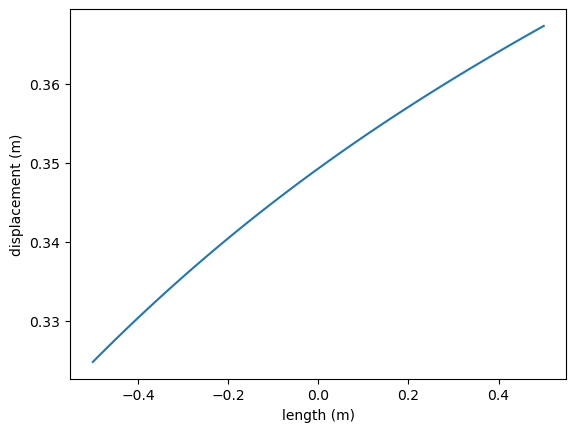

iteration 1000 resloss 1.00e+00
iteration 1000 boundary_loss 8.53e-12


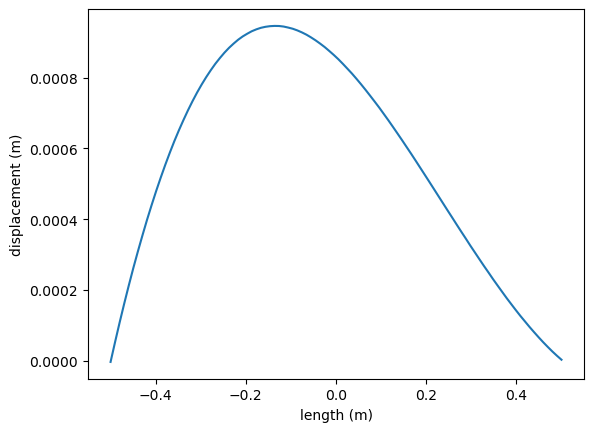

iteration 2000 resloss 1.00e+00
iteration 2000 boundary_loss 9.61e-12


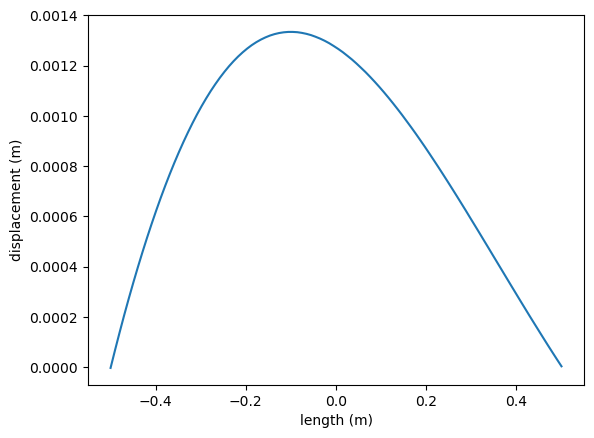

iteration 3000 resloss 1.00e+00
iteration 3000 boundary_loss 1.20e-11


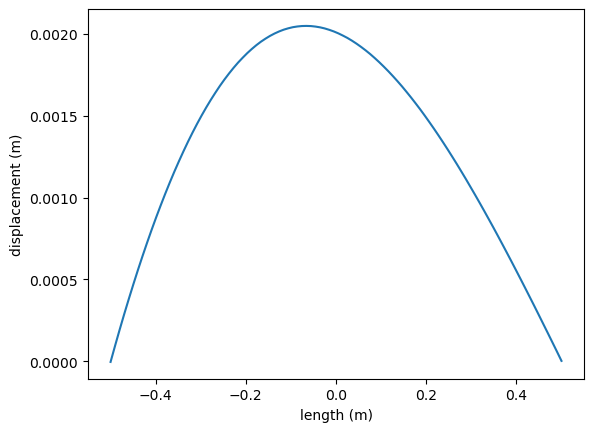

iteration 4000 resloss 9.99e-01
iteration 4000 boundary_loss 1.35e-11


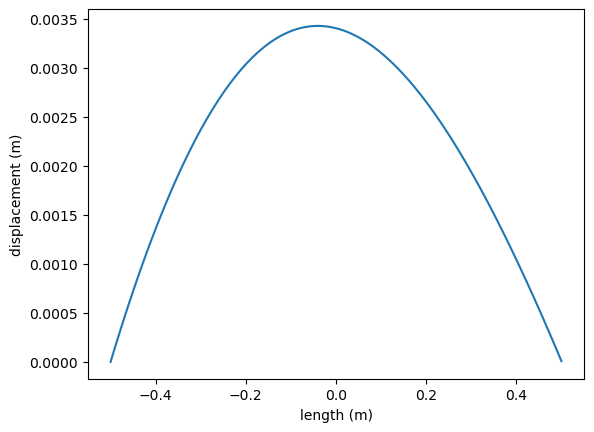

KeyboardInterrupt: 

In [4]:
pde = Pde(E=1e8, nu=0.3, h=0.001, k=5/6, l=1.0, q = 1.0)
model = PINN([1, 20, 20, 20, 4], lr=1.0e-3, dist=False)

iterations = 10001
report_step = 1000
rel_diff = 100.0

for i in range(iterations):
      model.optimizer.zero_grad()

      # Generate N collocation points
      x = getData(num_points=10, grad=True)

      # Generate N boundary points
      xb =  getBoundaryData(num_points=10, grad=True)
      
      resloss = pde.getLoss(model, x)

      _, bw, _, _ = model(xb).split(1, dim=1)
      boundary_loss = model.criterion(bw, torch.zeros_like(bw))

      loss = resloss + 1e3*boundary_loss
      loss.backward()

      model.optimizer.step()

      with torch.no_grad():
          if i % report_step ==0:
              print(f"iteration {i} resloss {resloss.item():.2e}")
              print(f"iteration {i} boundary_loss {boundary_loss.item():.2e}")
              plot_loss(model=model, eq=pde)
              print